    
# DATA DAY TRAINING: Intro to Python (data science workflow)

Topics to cover:

(i) Import data (from web and CSV files)

(ii) Clean and merge datasets

(iii) Exploratory data analysis

(iv) Visualization and modelling

We will cover this topic while exploring how life satisfaction in OECD countries varies with GNI per capita.

#### 1. Import libraries

Python provides several ways to import modules:

- import XYZ as x (to import module XYZ abbreviated as x)
- from XYZ import a, b, c (to import objects a, b, and c defined by module XYZ) 

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import wb
#import numpy as np
#import statsmodels.api as sm
#import geopandas as gpd

#### 2. Quick demo of pulling WDI data from the web
We're using Pandas Datareader: a third-party library that makes it easy to pull data from APIs into a Pandas dataframe.

Use it to pull live data from Yahoo! Finance, World Bank and others.


| Function | Task Performed |
|----|---|
| wb.get_countries()  | List available countries, with their country codes, income levels etc. |
| wb.search()  | Query the available indicators using a search term. |
| wb.WorldBankReader()  | A class for downloading data series. |


In [91]:
# Find the GNI per capita indicator, get its ID number

result = wb.search(string="GNI per capita, Atlas",field = 'name')
result

,id,name,source,sourceNote,sourceOrganization,topics,unit
8496,NY.GNP.PCAP.CD,"GNI per capita, Atlas method (current US$)",World Development Indicators,GNI per capita (formerly GNP per capita) is th...,"b'World Bank national accounts data, and OECD ...",Economy & Growth,


In [92]:
# Make a note of the indicator ID
GNI_ID = 'NY.GNP.PCAP.CD'

In [96]:
# Get a list of countries and clean it up
countries = wb.get_countries()
countries.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region
0,,Oranjestad,ABW,High income,AW,12.51670,Not classified,-70.0167,Aruba,Latin America & Caribbean
1,South Asia,Kabul,AFG,Low income,AF,34.52280,IDA,69.1761,Afghanistan,South Asia
2,,,AFR,Aggregates,A9,NaN,Aggregates,NaN,Africa,Aggregates
3,Sub-Saharan Africa (excluding high income),Luanda,AGO,Lower middle income,AO,-8.81155,IBRD,13.2420,Angola,Sub-Saharan Africa
4,Europe & Central Asia (excluding high income),Tirane,ALB,Upper middle income,AL,41.33170,IBRD,19.8172,Albania,Europe & Central Asia


In [94]:
#Select only those observations and variables we need: 
countries = countries[countries.incomeLevel != 'Aggregates']
countries = countries[['name', 'iso3c','incomeLevel']]
countries.head()

,name,iso3c,incomeLevel
0,Aruba,ABW,High income
1,Afghanistan,AFG,Low income
3,Angola,AGO,Lower middle income
4,Albania,ALB,Upper middle income
5,Andorra,AND,High income


In [87]:
countries.shape

(218, 3)

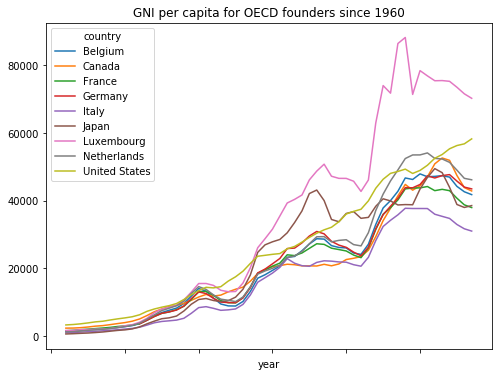

In [108]:
# Let's plot GNI per capita since 1960 for the OECD countries

OECD_founders = ['Belgium','France','Germany','Italy','Luxembourg','Netherlands','United States',
                'Canada','Japan']
OECD_founder_codes = countries.iso3c[countries.name.isin(OECD_founders)]

# Create a reader object, pass it the data ID and country codes we want

reader = wb.WorldBankReader(symbols=GNI_ID,countries = OECD_founder_codes,start=1960)
GNI_capita = reader.read()
GNI_capita.head()

GNI_capita = GNI_capita.unstack(level=0)[GNI_ID]
GNI_capita.head()

GNI_capita.plot(figsize=[8,6])
plt.title('GNI per capita for OECD founders since 1960');

#### 2. Combine income and life satisfaction data for 2015
Incomes have risen sharply. But does that translate into more life satisfaction, and are richer countries happier?

Let's do a cross-sectional analysis for a single year. 

#### 2.1 Import and clean up the OECD life satisfaction survey

In [111]:
# Read data from a CSV file using Pandas

CSV_path = 'https://raw.githubusercontent.com/worldbank/python-101/master/notebooks/BLI2015.csv'
life_sat = pd.read_csv(CSV_path)

In [112]:
life_sat = life_sat[(life_sat.Inequality == "Total") & (life_sat.Indicator == 'Life satisfaction')]
life_sat = life_sat[['Country','LOCATION','Value']]

In [113]:
# Remove two values that don't match across datasets

life_sat = life_sat[~life_sat.Country.str.contains("OECD")]
life_sat = life_sat[~life_sat.Country.str.contains("Korea")]

# Rename columns
life_sat.rename(columns = {'Country': 'country', 'LOCATION':'iso3c', 'Value':'life_satisfaction'},inplace=True)

In [114]:
# Inspect the dataframe
life_sat.head()

,country,iso3c,life_satisfaction
2669,Australia,AUS,7.3
2670,Austria,AUT,6.9
2671,Belgium,BEL,6.9
2672,Canada,CAN,7.3
2673,Czech Republic,CZE,6.5


#### 2.2 Get GNI per capita for OECD countries in 2015

In [73]:
# Read in the data

OECD_country_codes = life_sat.iso3c

reader = wb.WorldBankReader(symbols = GNI_ID, countries = OECD_country_codes, start = 2015, end = 2015)
GNI_OECD = reader.read()

In [74]:
# Tidy and preview

GNI_OECD = GNI_OECD[GNI_ID].unstack(level=0).T
GNI_OECD.rename(columns={'2015':'GNI_per_capita'},inplace=True)

GNI_OECD.head()

year,GNI_per_capita
country,
Australia,60360
Austria,47630
Belgium,44230
Brazil,10090
Canada,47460


#### 2.3 Merge the datasets

In [16]:
df = pd.merge(life_sat, GNI_OECD,on='country')
df = df[['country','life_satisfaction','GNI_per_capita']]
df.set_index('country',inplace=True)

#### 2.2 Get GNI per capita for OECD countries in 2015

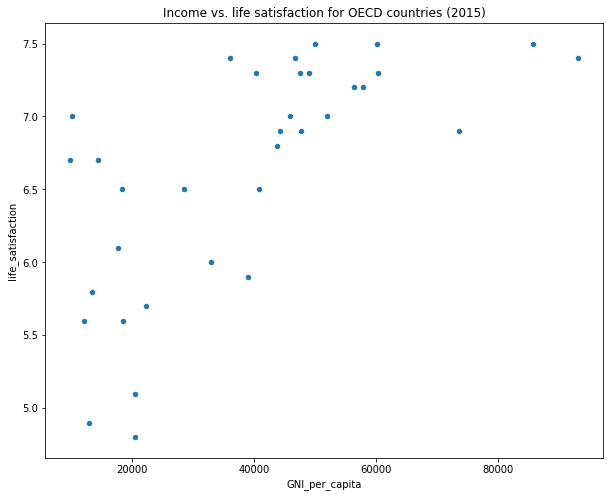

In [29]:
fig,ax = plt.subplots(figsize = [10,8])
df.plot(kind='scatter',x='GNI_per_capita',y='life_satisfaction',ax=ax)
plt.title('Income vs. life satisfaction for OECD countries (2015)');

In [39]:
df.head()

,life_satisfaction,GNI_per_capita
country,,
Australia,7.3,60360
Austria,6.9,47630
Belgium,6.9,44230
Canada,7.3,47460
Czech Republic,6.5,18250


In [70]:
df2 = df.reset_index()
df = df2

In [116]:
df.head()

,country,life_satisfaction,GNI_per_capita
0,Australia,7.3,60360
1,Austria,6.9,47630
2,Belgium,6.9,44230
3,Canada,7.3,47460
4,Czech Republic,6.5,18250


## EXERCISES:

We have looked at the tools Python has for data processing and cleaning, 
now lets explore the available functionality for statistical exploration of the data. 
At this stage, we want to do things like:
- check distribution of the variables using *df.describe()*
- get value counts, mostly useful for categorical variables: *df[col_name].value_counts()*
- sort the data: df.sort_values

frequently used Pandas functions' (.head,.columns)


Exercise 1: Display descriptive Statistics for the whole dataset (using dataframe.describe()

In [18]:
#Your code here: 




Exercise 2: What is the maximum GDP per capita in 2015? (using dataframe.col_name.max()

In [19]:
#Your code here:

In [119]:
#SAMPLE CODE:

#Which country has maximum value for life satisfaction in 2015 
max_sat = (df.life_satisfaction.idxmax())

print(df.loc[max_sat].country)

Denmark


Exercise 3: Which country has the minimum GDP per capita in 2015? (HINT: use column name=gdp_per_capita and idmin() 

In [ ]:
# Your code here: 

